<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Some-Firedrake-preliminaries" data-toc-modified-id="Some-Firedrake-preliminaries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Some Firedrake preliminaries</a></span></li><li><span><a href="#ODE-data-and-Discretization-Data" data-toc-modified-id="ODE-data-and-Discretization-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>ODE data and Discretization Data</a></span></li><li><span><a href="#Solve-a-1DRD-problem-with-a--Galerkin-method:" data-toc-modified-id="Solve-a-1DRD-problem-with-a--Galerkin-method:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Solve a 1DRD problem with a  Galerkin method:</a></span><ul class="toc-item"><li><span><a href="#Formulate-the-problem" data-toc-modified-id="Formulate-the-problem-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Formulate the problem</a></span></li><li><span><a href="#Solve" data-toc-modified-id="Solve-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Solve</a></span></li><li><span><a href="#Compute-errors" data-toc-modified-id="Compute-errors-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Compute errors</a></span></li><li><span><a href="#Plot-solutions" data-toc-modified-id="Plot-solutions-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Plot solutions</a></span></li></ul></li><li><span><a href="#Exercises" data-toc-modified-id="Exercises-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exercises</a></span></li></ul></div>

# 1. Getting started with Firedrake: solve a simple  1D problem

This notebook outlines how to solve a very simple, linear one-dimensional problem with Firedrake. 
It is part of Niall's [Introduction to Firedrake](https://niallmadden.ie/IntroToFiredrake)

The ODE we will solve is 
$$-\varepsilon u'' + r(x)u  = f(x) \text{ on } (0,1), \qquad\text{ with } u(0)=u(1)=0.$$

We'll solve this problem using a stardard $P^1$ (continuous) Galerkin method.
The actual problem we'll solve is 
$-\frac{1}{10} u''(x) + e^{-x}u(x)  = f(x)$
where we take $f(x)=\sin(\pi x)(\epsilon^2 \pi^2+e^{-x})$, which is chosen so that $u(x)=\sin(\pi x)$.


[Niall Madden](https://www.niallmadden.ie/) _Nov 2024_

## Some Firedrake preliminaries

In [1]:
import os
if "OMP_NUM_THREADS" not in os.environ:
    os.environ["OMP_NUM_THREADS"] = "1"  

In [2]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt

##  ODE data and Discretization Data

In [3]:
epsilon = 1.0e-1
r = lambda x : exp(-x)
f = lambda x : sin(pi*x)*(epsilon*pi**2.0 + exp(-x)) 
u_true = lambda x : sin(pi*x)
N = 16 
mesh1D = UnitIntervalMesh(N)

## Solve a 1DRD problem with a  Galerkin method:

### Formulate the problem
The weak for of the ODE is $$\varepsilon (u',v') + (ru,v) = (f,v),$$
where here $(u,v):=\int_0^1 u(x)v(x) dx$, is the usual $L^2$ inner product.

Set up the finite element space

In [4]:
Ue = FiniteElement("CG", mesh1D.ufl_cell(), 1)
V = FunctionSpace(mesh1D, Ue)

The weak form of the ODE is $$\varepsilon (u',v') + (ru,v) = (f,v).$$ 

Define trial and test functions:

In [5]:
u = TrialFunction(V)
v = TestFunction(V)

We'll define `x` to be the spatial coordinate associated with the mesh. It is index by the dimension, but this is a one-dimensional problem, so only `x[0]` is defined.

In a slightly analogous way, we can represent the derivatives of $u$ and $v$ as `u.dx(0)` and `v.dx(0)`, where here the index says we are differentiating with respect to the first (and only) dimension.

In [6]:
x = SpatialCoordinate(mesh1D)
a = epsilon*u.dx(0)*v.dx(0)*dx + r(x[0])*u*v*dx
L = f(x[0])*v*dx    

Define the boundary conditions

In [7]:
BCs = DirichletBC(V, 0.0, "on_boundary")

### Solve

In [8]:
uN = Function(V)
solve(a == L, uN, bcs=BCs)

### Compute errors

In [9]:
Diff = Function(V)
Diff.interpolate(uN-u_true(x[0]))
L2 = sqrt(assemble(inner(Diff, Diff)*dx))
H1  = sqrt(assemble(inner(grad(Diff), grad(Diff))*dx))
Energy = sqrt( float(epsilon)*H1**2.0 + L2**2.0)

Diff_vec = np.abs(Diff.dat.data_ro)
Max  = Diff_vec.max()

print(f"Errors: L2={L2 : 8.3e}, H1={H1 : 8.3e}, Energy={Energy : 8.3e}, Max={Max : 8.3e}")

Errors: L2= 8.684e-04, H1= 2.739e-03, Energy= 1.226e-03, Max= 1.229e-03


### Plot solutions

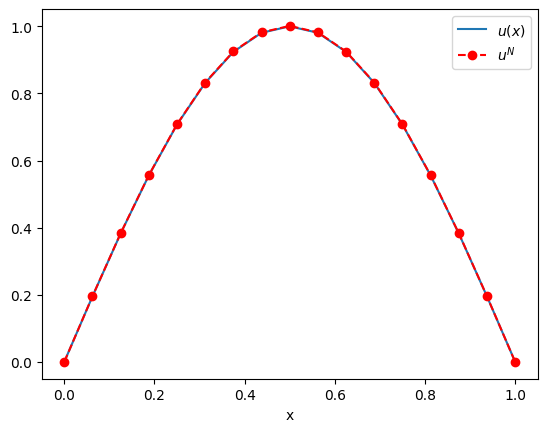

In [10]:
x_vals = mesh1D.coordinates.dat.data[:]
uE = Function(V); uE.interpolate(u_true(x[0]))  

plot(uE, label='$u(x)$') # true
# plot(uN, axes=axes, label='uN')   # Use this for large N
plt.plot(x_vals, uN.dat.data[:],'r--o', label='$u^N$')  # use for small N
plt.xlabel("x")
plt.legend()

## Exercises

1. Alter this code to add a function which takes as its inputs (say), a mesh, epsilon, r and f, and returns the computed solution.
2. Also write a function that computes the various errors, which are returned as a tupple.
3. Verify convergence by solving for various $N$, and computing errors in various norms.
